# TTC Bus Delay Report

## Authors
Agam Sanghera, Ashita Diwan, Cheng Zhang, Yichun Liu

## Summary

This report examines the 2024 TTC bus delay dataset to forecast delay times based on factors such as route, incident type, location, and time. We aim to classify delays into short, medium, and long categories using a logistic regression model. This study acts as a foundation for the implementation of real-time prediction models that could aid the Toronto Transit Commission in resource allocation and improving schedule adherence.

## Introduction

Public transportation systems, such as Toronto's TTC, are essential for facilitating commuter mobility. However, delays are unavoidable and can affect the efficiency of services. Anticipating these delays may enhance operational decision-making and increase commuter satisfaction. The objective of this analysis is to identify the primary factors contributing to delays and to accurately forecast the duration of these delays by utilizing route, incident types, location, and time-related features as predictors.

## Data

The data for this analysis was sourced from the [open.toronto.ca](http://open.toronto.ca) website, with a specific emphasis on the bus delay data for the year 2024. This dataset contains multiple incident reports, including information on route number, delay duration, incident type, and incident location. Raw data can be found [here](https://open.toronto.ca/dataset/ttc-bus-delay-data/).

## EDA Analysis

We will first conduct an EDA analysis on the data. The steps include:
1. **Loading and Preprocessing Data:** Handling missing values, converting timestamp data to day parts, and cleaning data fields irrelevant to our delay analysis.
2. **Visualization:** Analyze the distribution of delays, identify top routes and locations with frequent delay incidents, and visualize delays based on day and incident type.

In [46]:
# This code block will be used for all library imports. 
import pandas as pd
import altair as alt

# Simplify working with large datasets in Altair
alt.data_transformers.enable('vegafusion')

DataTransformerRegistry.enable('vegafusion')

### Loading and Fixing Data

In [47]:
# Let's load the data.
# the Dates column is parsed through date argument to make sure it is seen as datetime object.
ttc = pd.read_csv('../data/raw/ttc-bus-delay-data-2024.csv', parse_dates=['Date'])

/var/folders/m3/7mxrzzgs65x1zsl77zk_xn640000gn/T/ipykernel_5645/318762077.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ttc = pd.read_csv('../data/raw/ttc-bus-delay-data-2024.csv', parse_dates=['Date'])


In [48]:
ttc.head()

,Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle
0,2024-01-01,89,02:08,Monday,KEELE AND GLENLAKE,Vision,10,20,N,7107
1,2024-01-01,39,02:30,Monday,FINCH STATION,General Delay,20,40,NaN,8914
2,2024-01-01,300,03:13,Monday,BLOOR AND MANNING,General Delay,0,0,NaN,8562
3,2024-01-01,65,03:23,Monday,PARLIAMENT AND BLOOR,Security,0,0,N,8574
4,2024-01-01,113,03:37,Monday,MAIN STATION,Security,0,0,NaN,8541


In [49]:
# .shape shows up how big our data is
print(f"This dataset has {ttc.shape[0]} rows and {ttc.shape[1]} columns")
ttc.shape

This dataset has 45300 rows and 10 columns


(45300, 10)

In [50]:
# .info tells us about the object type for each column
# we can see 'Date' column was read as datetime object
ttc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45300 entries, 0 to 45299
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       45300 non-null  datetime64[ns]
 1   Route      44861 non-null  object        
 2   Time       45300 non-null  object        
 3   Day        45300 non-null  object        
 4   Location   45300 non-null  object        
 5   Incident   45300 non-null  object        
 6   Min Delay  45300 non-null  int64         
 7   Min Gap    45300 non-null  int64         
 8   Direction  38343 non-null  object        
 9   Vehicle    45300 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 3.5+ MB


In [51]:
# Let's also fix the 'Time' column
ttc1 = ttc.copy() # preserving the original

# Converting column to datetime object
ttc1['Time'] = pd.to_datetime(ttc['Time']).dt.time

/var/folders/m3/7mxrzzgs65x1zsl77zk_xn640000gn/T/ipykernel_5645/4215578345.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ttc1['Time'] = pd.to_datetime(ttc['Time']).dt.time


Now, let's split 'Date' column into 'Date_' and 'Month' (year is not needed since this is for 2024), and convert 'Time' into 'Hours' so it more useful in the analysis later on.

In [52]:
ttc1['Date_'] = ttc1['Date'].dt.date
ttc1['Month'] = ttc1['Date'].dt.month
ttc1['Hour'] = ttc1['Time'].map(lambda x: x.hour) # used ChatGPT for this conversion

In [53]:
# Let's drop the 'Date' and 'Time' column since they are no longer needed
ttc1 = ttc1.drop(columns=['Date', 'Time'])

### Preprocessing Data
Now that the data is loaded in, we want to make sure we don't perform our analysis will null values. So, we will go through and identify any columns that have big number of null values and determine if they are worth keeping for analysis or not. 

In [54]:
ttc1.isna().sum()

Route         439
Day             0
Location        0
Incident        0
Min Delay       0
Min Gap         0
Direction    6957
Vehicle         0
Date_           0
Month           0
Hour            0
dtype: int64

In [55]:
# 'Direction' column has a lot null values. Let's see if these rows can be dropped
ttc1[ttc1['Direction'].isna()].head(20)

,Route,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle,Date_,Month,Hour
1,39,Monday,FINCH STATION,General Delay,20,40,NaN,8914,2024-01-01,1,2
2,300,Monday,BLOOR AND MANNING,General Delay,0,0,NaN,8562,2024-01-01,1,3
4,113,Monday,MAIN STATION,Security,0,0,NaN,8541,2024-01-01,1,3
12,600,Monday,LAKESHORE AND THIRTY S,Cleaning - Unsanitary,25,50,NaN,8798,2024-01-01,1,5
13,300,Monday,KIPLING STATION,Emergency Services,0,0,NaN,3330,2024-01-01,1,5
23,41,Monday,KEELE AND IAN MACDONAL,Diversion,780,793,NaN,7251,2024-01-01,1,7
24,85,Monday,TORONTO ZOO,Security,20,40,NaN,3495,2024-01-01,1,7
27,NaN,Monday,EGLINTON DIVISION,Operations - Operator,0,0,NaN,0,2024-01-01,1,8
28,12,Monday,KENNEDY STATION,Emergency Services,30,60,NaN,8408,2024-01-01,1,8
34,900,Monday,KIPLING STATION,Operations - Operator,14,28,NaN,3341,2024-01-01,1,9


<br>
Maybe deleting the rows isn't such a good idea because it makes up for a lot of overall data in the dataset. Instead, let's drop the column since we already have information about the route. For that reason, it is also okay to drop 'Vehicle' column as it is not needed for our goal of observing delays in busses.

In [56]:
ttc_clean = ttc1.drop(columns=['Direction', 'Vehicle'])
ttc_clean.head()

,Route,Day,Location,Incident,Min Delay,Min Gap,Date_,Month,Hour
0,89,Monday,KEELE AND GLENLAKE,Vision,10,20,2024-01-01,1,2
1,39,Monday,FINCH STATION,General Delay,20,40,2024-01-01,1,2
2,300,Monday,BLOOR AND MANNING,General Delay,0,0,2024-01-01,1,3
3,65,Monday,PARLIAMENT AND BLOOR,Security,0,0,2024-01-01,1,3
4,113,Monday,MAIN STATION,Security,0,0,2024-01-01,1,3


Now, let's look at the Route column and its NaNs. This column is particularly important for us for our goal.

In [57]:
na_route = ttc1[ttc1['Route'].isna()]
na_route.head(10)

,Route,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle,Date_,Month,Hour
27,NaN,Monday,EGLINTON DIVISION,Operations - Operator,0,0,NaN,0,2024-01-01,1,8
69,NaN,Monday,GUILDWOOD AND KINGSTON,Utilized Off Route,0,0,NaN,8491,2024-01-01,1,19
213,NaN,Tuesday,QUEENSWAY GARAGE,Mechanical,0,0,NaN,8136,2024-01-02,1,16
248,NaN,Tuesday,3RD FLOOR GUNN BUILDIN,Operations - Operator,0,0,NaN,0,2024-01-02,1,20
293,NaN,Wednesday,WILSON TRAINING OPERAT,Operations - Operator,0,0,NaN,0,2024-01-03,1,6
350,NaN,Wednesday,RUSSELL CARHOUSE,Mechanical,0,0,NaN,349,2024-01-03,1,14
602,NaN,Thursday,FINCH STATION,Operations - Operator,12,24,N,3253,2024-01-04,1,17
624,NaN,Thursday,ARROW GARAGE,Collision - TTC,0,0,NaN,1371,2024-01-04,1,21
638,NaN,Thursday,123 PARKWAY FOREST DRI,Utilized Off Route,0,0,NaN,3400,2024-01-04,1,0
659,NaN,Friday,MOUNT DENNIS DIVISION,Operations - Operator,0,0,NaN,0,2024-01-05,1,5


In [58]:
# Now, we will see how many for NaN routes have delays
na_route[na_route['Min Delay'] == 0].count()

Route          0
Day          363
Location     363
Incident     363
Min Delay    363
Min Gap      363
Direction     68
Vehicle      363
Date_        363
Month        363
Hour         363
dtype: int64

Since all the NaN routes have 0 delays, it is safe to drop these rows. We will also remove all other null values to ensure a clean dataset to work with

In [59]:
ttc_clean = ttc_clean.dropna()
ttc_clean.isna().sum()

Route        0
Day          0
Location     0
Incident     0
Min Delay    0
Min Gap      0
Date_        0
Month        0
Hour         0
dtype: int64

In [60]:
ttc_clean.head()

,Route,Day,Location,Incident,Min Delay,Min Gap,Date_,Month,Hour
0,89,Monday,KEELE AND GLENLAKE,Vision,10,20,2024-01-01,1,2
1,39,Monday,FINCH STATION,General Delay,20,40,2024-01-01,1,2
2,300,Monday,BLOOR AND MANNING,General Delay,0,0,2024-01-01,1,3
3,65,Monday,PARLIAMENT AND BLOOR,Security,0,0,2024-01-01,1,3
4,113,Monday,MAIN STATION,Security,0,0,2024-01-01,1,3


### Visualizing

Now it's the fun part: visualizations!

Let's look at how the delays are distributed in this data

In [61]:
# Filter data
ttc_filtered = ttc_clean[ttc_clean['Min Delay'] < 200]

# Creating histogram
delay_dist = alt.Chart(ttc_filtered).mark_bar().encode(
    alt.X('Min Delay:Q', bin=alt.Bin(maxbins=50), title='Delay (in minutes)'),
    alt.Y('count()', title='Frequency')
).properties(
    title='Distribution of Delays',
)

delay_dist.save("delay_dist.png",ppi=600)
# Display
delay_dist


alt.Chart(...)

This plot shows that majority of the delays occur within 0 to 25 mins. This can indicate that most delays are short in duration.

___
Now let's take a look at top 20 routes with highest delay incidents

In [62]:
# Group by 'Route' and count the occurrences
route_counts = ttc_clean.groupby('Route').size().reset_index(name='Count')

# Sort counts in descending order and get the top 20 routes
route_counts = route_counts.sort_values('Count', ascending=False)
top_routes = route_counts.head(20)
#top_routes

# Creating bar chart
top20_delay_routes = alt.Chart(top_routes).mark_bar().encode(
    alt.X('Route:N', title='Route', sort=alt.EncodingSortField(field='Count', order='descending')),  # 'N' for nominal (categorical)
    alt.Y('Count:Q', title='Count'),  # 'Q' for quantitative (numerical)
    alt.Color('Count:Q')
).properties(
    title='Top 20 Routes with Highest Delay Incidents',
)
top20_delay_routes.save("top20_delay_routes.png",ppi=600)
# Display
top20_delay_routes

alt.Chart(...)

This plot shows that majority of the incidents are occuring on route 32 with close to 1,400 counts of delays, followed by route 32 and 36.
As we move towards other routes, there seems to be a smooth decline in delay counts, showing a decreasing trend.

In [63]:
# Top 10 locations with Highest Delay Counts

# Filter rows where 'Min Delay' is greater than 0 (i.e., there is an actual delay)
delayed_ttc = ttc[ttc['Min Delay'] > 0]

# Group by 'Location' and count the number of delays (i.e., count occurrences where 'Min Delay' > 0)
delay_counts = delayed_ttc.groupby('Location')['Min Delay'].count().reset_index()

# Rename the column for clarity
delay_counts = delay_counts.rename(columns={'Min Delay': 'Delay Count'})

# Sort by 'Delay Count' in descending order
delay_counts_sorted = delay_counts.sort_values(by='Delay Count', ascending=False)

# Select the top 10 locations with the highest delay counts
top_10_locations = delay_counts_sorted.head(10)

# Display the top 10 locations with the highest delay counts
print(top_10_locations)

                    Location  Delay Count
3675         KENNEDY STATION         1263
3955         KIPLING STATION          820
2326        EGLINTON STATION          688
7713          WILSON STATION          628
2734           FINCH STATION          623
5544  PIONEER VILLAGE STATIO          575
5986  SCARBOROUGH CENTRE STA          431
7365          WARDEN STATION          419
8026      YORK MILLS STATION          377
1688       DON MILLS STATION          371


In [64]:
# Create a bar chart of the top 10 locations with the highest delay counts
chart = alt.Chart(top_10_locations).mark_bar().encode(
    x=alt.X('Delay Count:Q', title='Delay Count'),
    y=alt.Y('Location:N', title='Location', sort='-x'),  # Sort by delay count (descending)
    color='Location:N'
).properties(
    title='Top 10 Locations with the Highest Delay Counts'
)

chart.save("top10_locations.png",ppi=600)
chart.show()

alt.Chart(...)

In [65]:
# Delay Counts by Day of the Week

delay_counts_day = delayed_ttc.groupby('Day')['Min Delay'].count().reset_index()
delay_counts_day = delay_counts_day.rename(columns={'Min Delay': 'Delay Count'})
delay_counts_day = delay_counts_day.sort_values(by='Delay Count', ascending=False)
print("\nDelay Counts by Day of the Week")
print(delay_counts_day)


# Plot delay counts by Day of the Week
chart_month = alt.Chart(delay_counts_day).mark_bar().encode(
    x=alt.X('Day:O', title='Day of the Week'),
    y=alt.Y('Delay Count:Q', title='Delay Count'),
    color='Day:O'
).properties(
    title='Delay Counts by Day of the Week'
)
chart_month.save("chart_month.png",ppi=600)
chart_month.show()


Delay Counts by Day of the Week
         Day  Delay Count
0     Friday         6541
5    Tuesday         6198
4   Thursday         6189
6  Wednesday         6038
2   Saturday         5662
1     Monday         5441
3     Sunday         4149


alt.Chart(...)

In [66]:
delay_counts_incident = delayed_ttc.groupby('Incident')['Min Delay'].count().reset_index()
delay_counts_incident = delay_counts_incident.rename(columns={'Min Delay': 'Delay Count'})
delay_counts_incident = delay_counts_incident.sort_values(by='Delay Count', ascending=False)

print("Delay Counts by Incident Type")
print(delay_counts_incident)


# Visualize delay counts by Incident Type
chart_incident = alt.Chart(delay_counts_incident).mark_bar().encode(
    x=alt.X('Incident:N', title='Incident Type', sort='-y'),  # Sort by Delay Count
    y=alt.Y('Delay Count:Q', title='Delay Count'),
    color='Incident:N'
).properties(
    title='Delay Counts by Incident Type'
)
chart_incident.save("chart_incident.png",ppi=600)
chart_incident.show()

Delay Counts by Incident Type
                            Incident  Delay Count
6                         Mechanical        14846
7              Operations - Operator         7483
2                          Diversion         3125
9                           Security         2838
1                    Collision - TTC         2772
3                 Emergency Services         1978
10                Utilized Off Route         1953
0              Cleaning - Unsanitary         1764
11                            Vision         1372
4                      General Delay         1192
5                      Investigation          772
8   Road Blocked - NON-TTC Collision          123


alt.Chart(...)

## Linear Regression Model for Prediction

The EDA analysis was very informative in understanding the columns of interest for this project. The columns which seem to impact the Min Delay are Incident and Route, so this analysis will be focused around using these 2 columns to create a Logistic Regression model, to predict the expected delay given a route and incident. The delay output will be categorized into "Short", "Medium" or "Long". Cross-validation and randomized grid search were applied for hyperparameter tuning to enhance model performance.

First the required libraries are loaded to perrform the analysis.

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

To perform the analysis, the cleaned data from the EDA will be used.

In [68]:
ttc_clean.reset_index(drop=True, inplace=True)
ttc_clean

,Route,Day,Location,Incident,Min Delay,Min Gap,Date_,Month,Hour
0,89,Monday,KEELE AND GLENLAKE,Vision,10,20,2024-01-01,1,2
1,39,Monday,FINCH STATION,General Delay,20,40,2024-01-01,1,2
2,300,Monday,BLOOR AND MANNING,General Delay,0,0,2024-01-01,1,3
3,65,Monday,PARLIAMENT AND BLOOR,Security,0,0,2024-01-01,1,3
4,113,Monday,MAIN STATION,Security,0,0,2024-01-01,1,3
...,...,...,...,...,...,...,...,...,...
44856,63,Monday,KING AND DOWLING,Vision,10,20,2024-09-30,9,1
44857,32,Monday,EGLINTON AND OAKWOOD,Vision,13,18,2024-09-30,9,1
44858,63,Monday,OSSINGTON STATION,Vision,10,20,2024-09-30,9,1
44859,31,Monday,COXWELL STATION,Emergency Services,17,34,2024-09-30,9,1


Seeing as the data has alot of extreme values, the outliers will be eliminated. These outliers are delays greater than 30 minutes and less than 1 minute.

In [69]:
ttc_lr = ttc_clean.loc[(ttc_clean["Min Delay"]<30) & (ttc_clean["Min Delay"]>0)].reset_index(drop=True)

Next, the `Min Delay` column needs to be pre processed as there are multiple unique values and predicting on such values is not efficient, thus the times are divided in 3 classes:
* Short Delay: delays less than or equal to 10 minutes
* Medium Delay: Delays of more than 10 minutes but less than or equal to 20 minutes
* Long Delays: Delays greater than 20 minutes

In [70]:
ttc_lr["Min Delay"] = ttc_lr["Min Delay"].apply(lambda x: "Short Delay" if type(x)== int and x >0 and x<=10 else x)
ttc_lr["Min Delay"] = ttc_lr["Min Delay"].apply(lambda x: "Medium Delay" if type(x)== int and  x >10 and x<=20 else x)
ttc_lr["Min Delay"] = ttc_lr["Min Delay"].apply(lambda x: "Long Delay" if type(x)== int and  x >=10 else x)
ttc_lr

,Route,Day,Location,Incident,Min Delay,Min Gap,Date_,Month,Hour
0,89,Monday,KEELE AND GLENLAKE,Vision,Short Delay,20,2024-01-01,1,2
1,39,Monday,FINCH STATION,General Delay,Medium Delay,40,2024-01-01,1,2
2,320,Monday,YONGE AND QUEENSQUAY,Operations - Operator,Short Delay,16,2024-01-01,1,3
3,171,Monday,MOUNT DENNIS GARAGE,General Delay,Medium Delay,20,2024-01-01,1,4
4,12,Monday,VICTORIA PARK AND DANF,Emergency Services,Long Delay,42,2024-01-01,1,4
...,...,...,...,...,...,...,...,...,...
35251,63,Monday,KING AND DOWLING,Vision,Short Delay,20,2024-09-30,9,1
35252,32,Monday,EGLINTON AND OAKWOOD,Vision,Medium Delay,18,2024-09-30,9,1
35253,63,Monday,OSSINGTON STATION,Vision,Short Delay,20,2024-09-30,9,1
35254,31,Monday,COXWELL STATION,Emergency Services,Medium Delay,34,2024-09-30,9,1


In [71]:
#Split dataset into target and features
X = ttc_lr[["Route","Incident","Location","Day","Hour","Month"]]
y = ttc_lr['Min Delay']

In [72]:
#Create types of features
numeric_features=["Hour","Month"]
categorical_features = ['Location', 'Route', 'Incident',"Day"]

In [73]:
#Create transformers and preprocessing pipeline
preprocessor = ColumnTransformer(
   transformers=[
       ('num', StandardScaler(), numeric_features),
       ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
   ]
)
preprocessor

ColumnTransformer(transformers=[('num', StandardScaler(), ['Hour', 'Month']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['Location', 'Route', 'Incident', 'Day'])])

In [74]:
#Create Model pipeline
model_pipeline = Pipeline(steps=[
   ('preprocessor', preprocessor),
   ('model', LogisticRegression(random_state=123, max_iter=2000))
])
model_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Hour', 'Month']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Location', 'Route',
                                                   'Incident', 'Day'])])),
                ('model', LogisticRegression(max_iter=2000, random_state=123))])

In [75]:
#Split dataset into train and test data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

Perform cross validation to see how the model performs

In [76]:
cv_pipe=cross_validate(model_pipeline, X_train, y_train, cv=5, return_train_score=True)
results_df=pd.DataFrame(pd.DataFrame(cv_pipe))
results_df

,fit_time,score_time,test_score,train_score
0,0.498094,0.010533,0.690480,0.772504
1,0.542970,0.010509,0.699699,0.766387
2,0.548084,0.010670,0.689949,0.771617
3,0.532044,0.010995,0.683389,0.773878
4,0.571409,0.010146,0.702482,0.767550


We then conduct hyperparameter tuning to optimize results, using a parameter grid of values of the hyperparameter C in the range $10^{-5}$ to $10^{10}$ and then using it in a Randomized Search.

In [77]:
param_dist = {
    "model__C": [10**i for i in range(-5,10)]
}
print("Grid size: %d" % (np.prod(list(map(len, param_dist.values())))))

Grid size: 15


In [78]:
random_search = RandomizedSearchCV(model_pipeline,param_dist, n_iter=15, n_jobs=-1,return_train_score=True,random_state=123)
random_search.fit(X_train,y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['Hour',
                                                                                'Month']),
                                                                              ('cat',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['Location',
                                                                                'Route',
                                                                                'Incident',
                                                                                'Day'])])),
                                             ('model',
                                              LogisticRegression(max_iter=2000,
                                                                 random_state=123))]),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'model__C': [1e-05, 0.0001, 0.001, 0.01,
                                                     0.1, 1, 10, 100, 1000,
                                                     10000, 100000, 1000000,
                                                     10000000, 100000000,
                                                     1000000000]},
                   random_state=123, return_train_score=True)

The selected model has the best train score with the smallest difference in train and validation scores, and indicating less overfitting. Thus the value of 0.1 is the value chosen for the final model.

In [79]:
b=pd.DataFrame(pd.DataFrame(random_search.cv_results_).iloc[4])
b.T[["params","mean_train_score","mean_test_score"]]

,params,mean_train_score,mean_test_score
4,{'model__C': 0.1},0.717478,0.693342


Create optimized pipiline with updated C

In [80]:
optimized_pipe= Pipeline(steps=[
   ('preprocessor', preprocessor),
   ('model', LogisticRegression(random_state=123, max_iter=2000,C=0.1))
])

In [81]:
#Fitting the model
optimized_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Hour', 'Month']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Location', 'Route',
                                                   'Incident', 'Day'])])),
                ('model',
                 LogisticRegression(C=0.1, max_iter=2000, random_state=123))])

Making predictions on the optimized model

In [82]:
predictions = optimized_pipe.predict(X_test)

In [83]:
# Define order explicitly to reorder bars
order=["Short","Medium","Long"]

Create visualization for visually comparing the model performance.

/var/folders/m3/7mxrzzgs65x1zsl77zk_xn640000gn/T/ipykernel_5645/2532171593.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(labels=order)
/var/folders/m3/7mxrzzgs65x1zsl77zk_xn640000gn/T/ipykernel_5645/2532171593.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(labels=order)


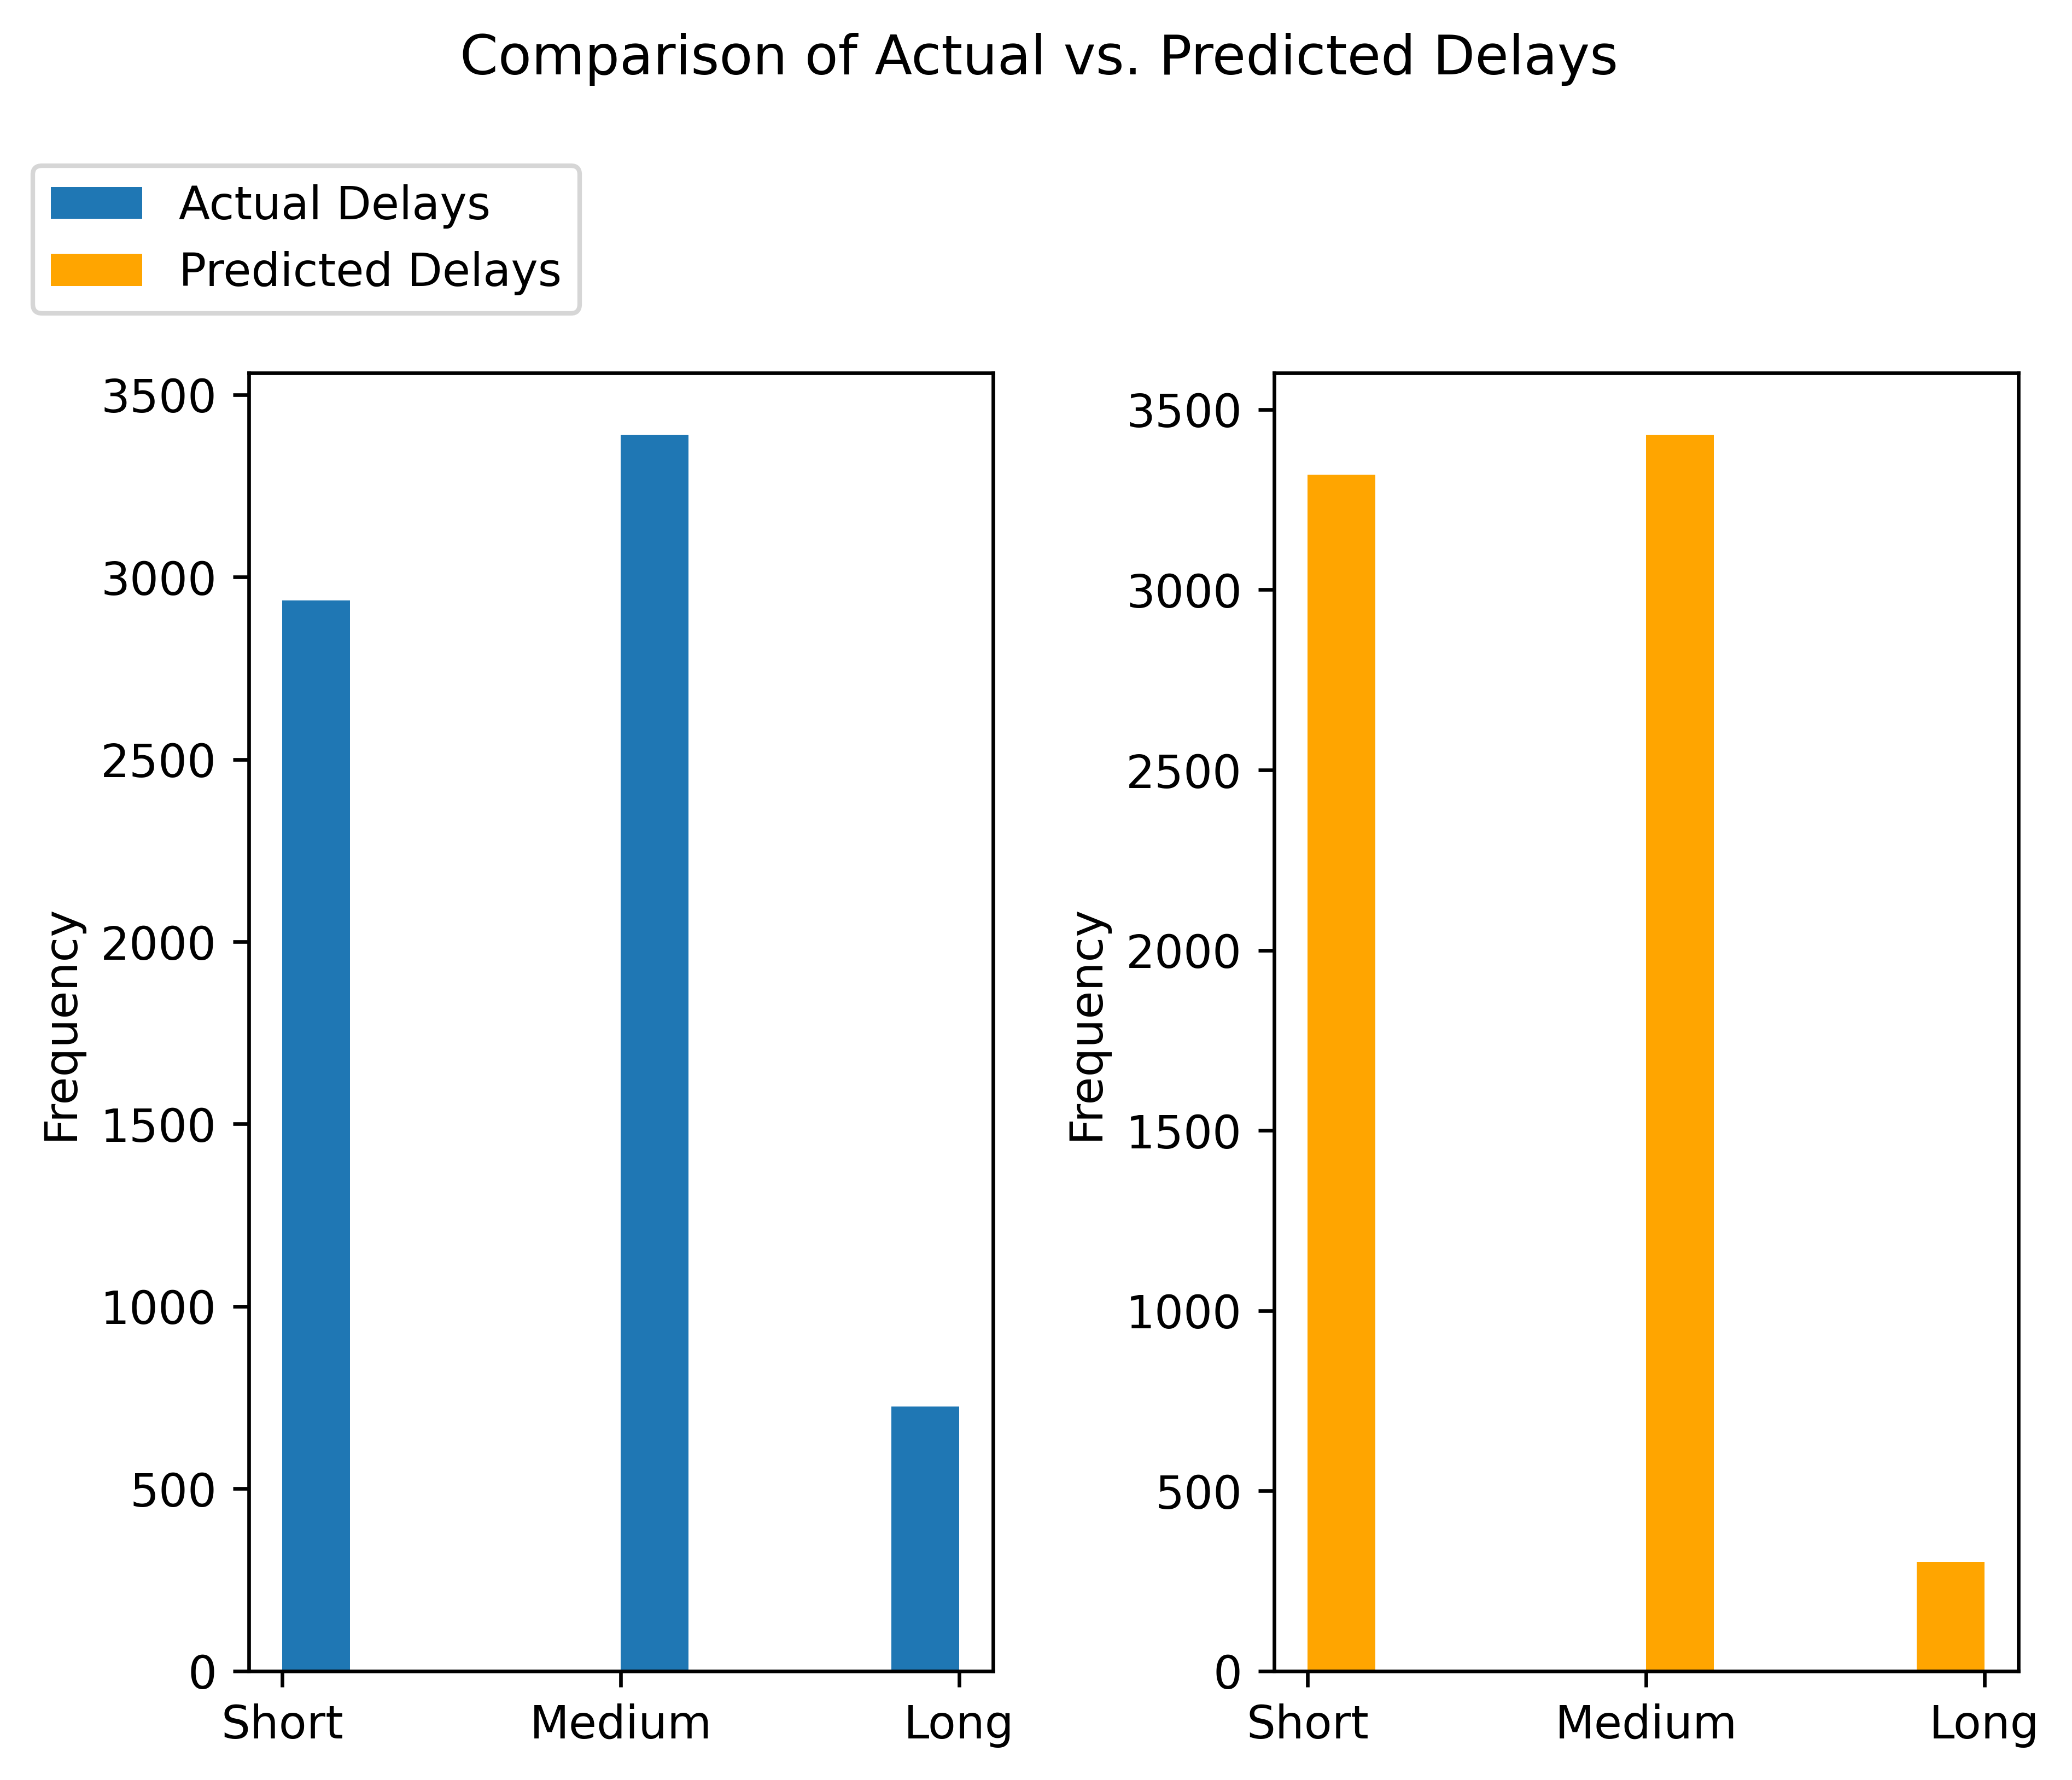

In [84]:
fig,ax=plt.subplots(1,2)
fig.set_dpi(600)
fig.set_label(["Actual Delays","Predicted Delays"])
ax[0].hist( y_test, label='Actual Delays')
ax[0].set_xticklabels(labels=order)
ax[0].set_ylabel('Frequency')
ax[1].hist( predictions, label='Predicted Delays',color="orange")
ax[1].set_xticklabels(labels=order)
ax[1].set_ylabel('Frequency')
fig.legend(loc="upper left",bbox_to_anchor=(0.01, 1.05))
fig.suptitle('Comparison of Actual vs. Predicted Delays', y=1.12)

plt.tight_layout()
plt.savefig("Comparison.png")
plt.show()


In [98]:
y1=y_test.to_list()

In [122]:
cm=confusion_matrix(y1,predictions)

AttributeError: 'NoneType' object has no attribute 'savefig'

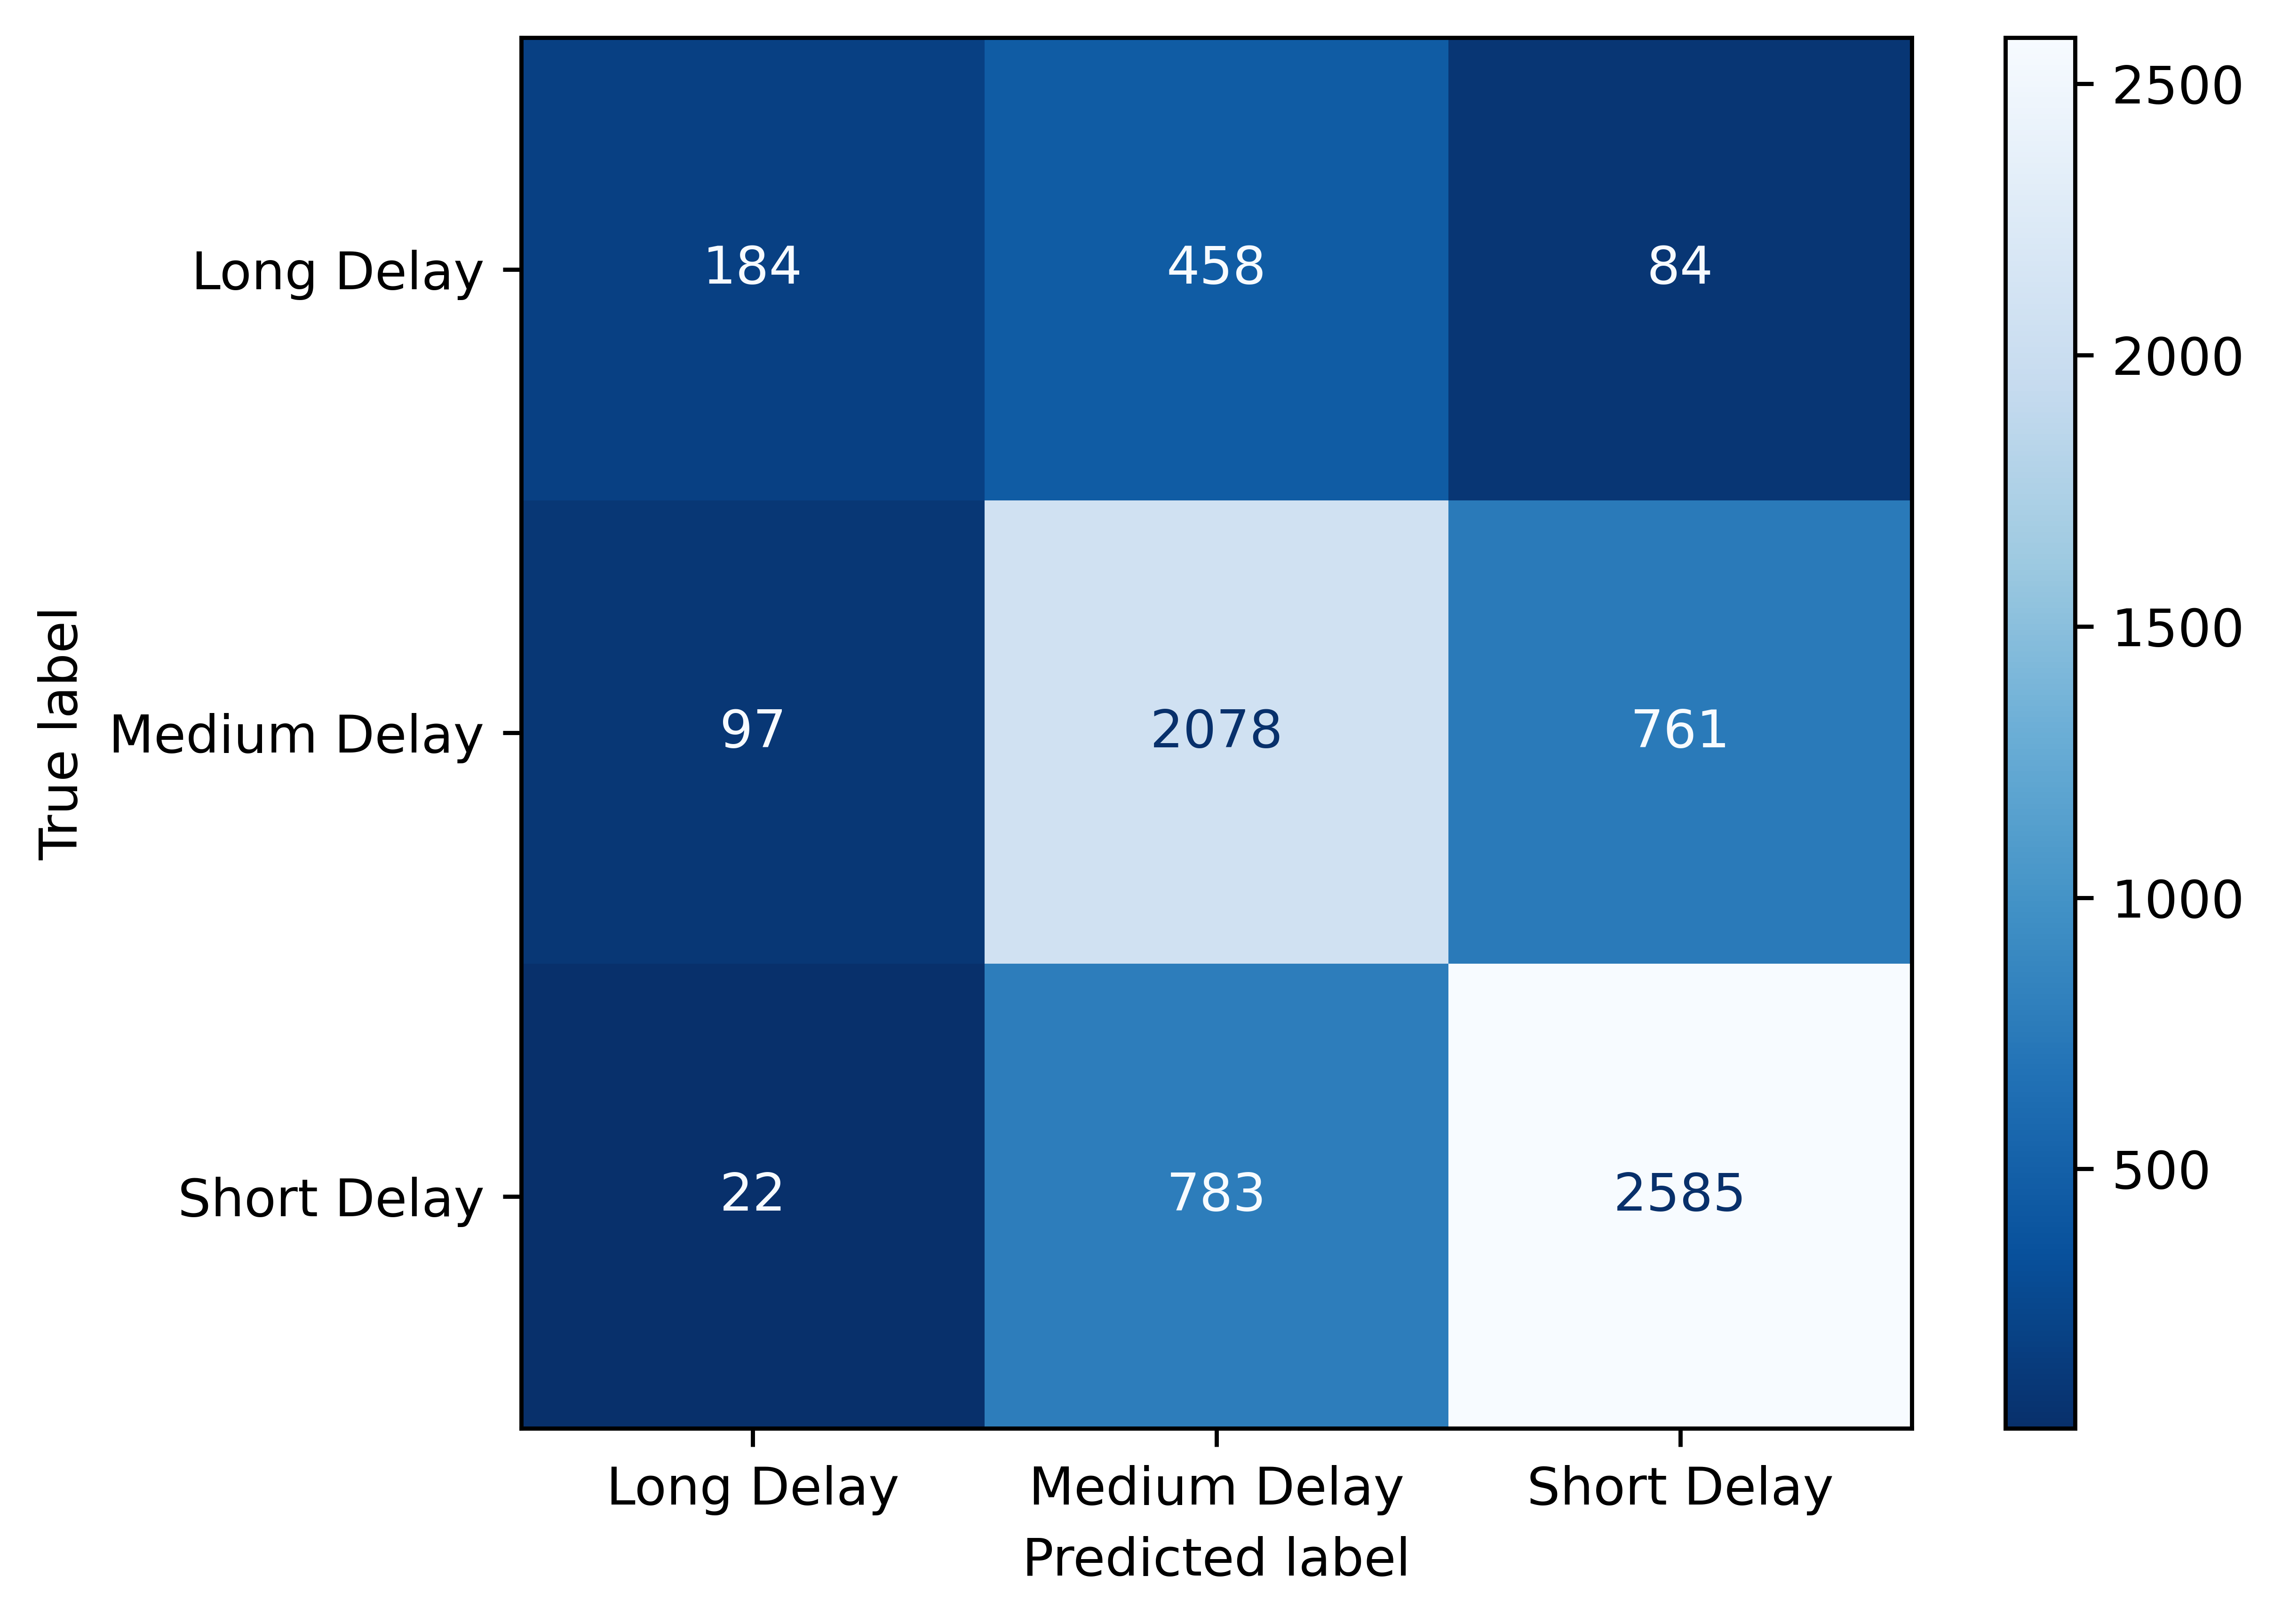

In [162]:
fig1=ConfusionMatrixDisplay.from_predictions(y1,predictions,
                              cmap='Blues_r').figure_.set_dpi(800).savefig("ConfusionMat.png",transparent=True)
fig1.savefig("ConfusionMat.png",transparent=True)

In [160]:

fig1.savefig("ConfusionMat.png",transparent=True)


AttributeError: 'NoneType' object has no attribute 'savefig'

In [155]:
print(f)

Figure(51.2x38.4)


## Discussion of Results

The EDA analysis of the TTC bus delay data uncovers several key insights. The distribution of delays is significantly biased towards shorter durations, with the majority of delays lasting less than 20 minutes. This indicates that although delays occur frequently, they are typically short and manageable.

Kennedy Station stands out as the site with the highest number of delays, suggesting that either infrastructural limitations or a high volume of passengers are contributing to these frequent interruptions. The analysis of delay counts by day of the week indicates that Tuesday through Friday are the days with the highest delays, suggesting a potential correlation with weekday commuter traffic.

Mechanical issues are the primary cause of delays, comprising a substantial portion, followed by operator-related operations and diversions. This finding indicates potential areas for intervention, such as improved maintenance or optimized scheduling, to mitigate delay incidents.

The results of the logistic regression model show moderate effectiveness in predicting delay durations. Predicted frequencies for short and medium delays correspond with actual data; however, the model underpredicts long delays, highlighting the complexity of accurately capturing extended durations and their contributing factors. We could explore more advanced predictive models to improve accuracy. Furthermore, more data integration such as weather conditions could enhance model performance.

Data Validation

In [103]:
# Correct data file format

import os
import pandas as pd

file_path = '../data/ttc-bus-delay-data-2024.csv'

if os.path.exists(file_path) and file_path.endswith('.csv'):
    try:
        # Load the CSV file and parse dates
        ttc = pd.read_csv(file_path, parse_dates=['Date'])
        print("File loaded successfully!")
    except Exception as e:
        print(f"Error loading file: {e}")
else:
    print("Error: File is either missing or not in CSV format.")

File loaded successfully!


/var/folders/m3/7mxrzzgs65x1zsl77zk_xn640000gn/T/ipykernel_40993/4209968046.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ttc = pd.read_csv(file_path, parse_dates=['Date'])


The warning suggests that the pd.read_csv() method couldn't infer a uniform date format for the Date column. This happens when the column contains inconsistent date formats or unparseable values. This was fixed when we used parse_dates=['Date'] in ttc = pd.read_csv('data/ttc-bus-delay-data-2024.csv', parse_dates=['Date'])